1. **Simple Mean Reversion**: Bet on prices returning to their historical average.
5. **Z-Score Reversion**: Trade based on the Z-score deviation from the mean.

In [1]:
#Loading the libraries
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import warnings
import pandas_ta
warnings.filterwarnings('ignore')
from datetime import timedelta

In [30]:
stock=['AAPL','SPY']
end_date='2024-08-15'
start_date=pd.to_datetime(end_date)-pd.DateOffset(365*8)
df=yf.download(stock, start=start_date, end=end_date).stack()
df.index.names=['date','ticker']
df.reset_index()

[*********************100%%**********************]  2 of 2 completed


Price,date,ticker,Adj Close,Close,High,Low,Open,Volume
0,2016-08-17,AAPL,25.185980,27.305000,27.342501,27.084999,27.275000,101424000
1,2016-08-17,SPY,190.413971,218.369995,218.529999,217.020004,218.000000,75134300
2,2016-08-18,AAPL,25.153702,27.270000,27.400000,27.254999,27.307501,87938800
3,2016-08-18,SPY,190.841248,218.860001,218.899994,218.210007,218.339996,52989300
4,2016-08-19,AAPL,25.218269,27.340000,27.422501,27.090000,27.192499,101472400
...,...,...,...,...,...,...,...,...
4017,2024-08-12,SPY,533.270020,533.270020,535.729980,530.950012,534.210022,42542100
4018,2024-08-13,AAPL,221.270004,221.270004,221.889999,219.009995,219.009995,44155300
4019,2024-08-13,SPY,542.039978,542.039978,542.280029,536.280029,536.530029,52333100
4020,2024-08-14,AAPL,221.720001,221.720001,223.029999,219.699997,220.570007,41960600


In [31]:
#check for missing data
df.isna().sum()
# # Now, for decomposition...
# decomposed_aapl_volume = sm.tsa.seasonal_decompose(df["High"],period=360) # The frequncy is annual
# figure = decomposed_aapl_volume.plot()
# plt.show()

Price
Adj Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
dtype: int64

In [47]:
#define the rolling window and the rolling mean and standard deviation for both AAPL and SPY
window = 20
# rolling_mean=df.rolling(window=window).mean()
# rolling_std=df.rolling(window=window).std()


In [68]:
data=df.copy().unstack()

data_filtered=data.drop(columns=['Volume','Open','Close','Low','High'], level=0)

data_filtered.reset_index
# df_flat=data_filtered.rename_axis(None, axis=1)
df_flat = data_filtered.copy()
df_flat.columns=df_flat.columns.droplevel(0)
df_flat.columns.name = None 
print(df_flat)

                  AAPL         SPY
date                              
2016-08-17   25.185980  190.413971
2016-08-18   25.153702  190.841248
2016-08-19   25.218269  190.562134
2016-08-22   25.022264  190.553467
2016-08-23   25.100658  190.937180
...                ...         ...
2024-08-08  213.063385  530.650024
2024-08-09  215.990005  532.989990
2024-08-12  217.529999  533.270020
2024-08-13  221.270004  542.039978
2024-08-14  221.720001  543.750000

[2011 rows x 2 columns]


In [74]:
rolling_mean=df_flat.rolling(window=window).mean()
rolling_std=df_flat.rolling(window=window).std()

z_score=(df_flat-rolling_mean)/rolling_std
#Generating signals based on Simple Mean Reversion
simple_mean_reversion_signals=pd.DataFrame(index=df_flat.index)
simple_mean_reversion_signals['AAPL'] = np.where(df_flat['AAPL'] > rolling_mean['AAPL'], -1, 1)
simple_mean_reversion_signals['SPY'] = np.where(df_flat['SPY'] > rolling_mean['SPY'], -1, 1)

In [75]:
#Generate signals based on Z-Score Reversion
z_threshold=2
z_score_signals=pd.DataFrame(index=df_flat.index)
z_score_signals['AAPL']=np.where(z_score['AAPL']>z_threshold, -1, np.where(z_score['AAPL']<-z_threshold,1,0))
z_score_signals['SPY']=np.where(z_score['SPY']>z_threshold, -1, np.where(z_score['SPY']<-z_threshold,1,0))

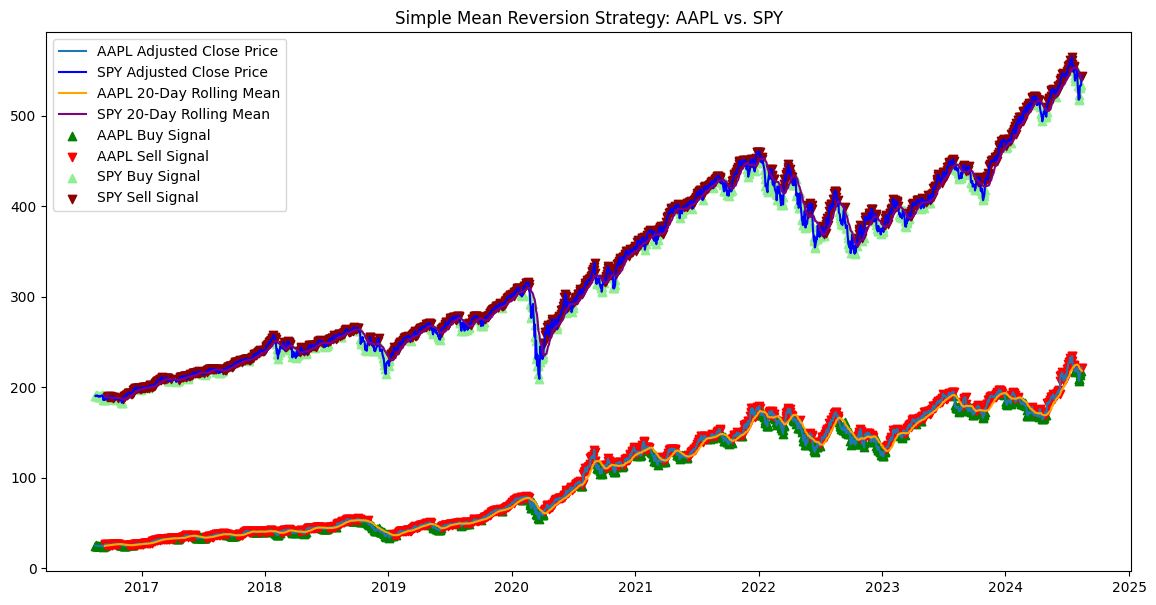

In [81]:
#Plotting simple mean reversion
plt.figure(figsize=(14,7))
plt.plot(df_flat['AAPL'],label='AAPL Adjusted Close Price')
plt.plot(df_flat['SPY'],label='SPY Adjusted Close Price',color='blue')
plt.plot(rolling_mean['AAPL'], label=f'AAPL {window}-Day Rolling Mean', color='orange')
plt.plot(rolling_mean['SPY'], label=f'SPY {window}-Day Rolling Mean', color='purple')
plt.scatter(df_flat.index, df_flat['AAPL'].where(simple_mean_reversion_signals['AAPL'] == 1), color='green', label='AAPL Buy Signal', marker='^', alpha=1)
plt.scatter(df_flat.index, df_flat['AAPL'].where(simple_mean_reversion_signals['AAPL'] == -1), color='red', label='AAPL Sell Signal', marker='v', alpha=1)
plt.scatter(df_flat.index, df_flat['SPY'].where(simple_mean_reversion_signals['SPY'] == 1), color='lightgreen', label='SPY Buy Signal', marker='^', alpha=1)
plt.scatter(df_flat.index, df_flat['SPY'].where(simple_mean_reversion_signals['SPY'] == -1), color='darkred', label='SPY Sell Signal', marker='v', alpha=1)
plt.title(f'Simple Mean Reversion Strategy: AAPL vs. SPY')
plt.legend()
plt.show()

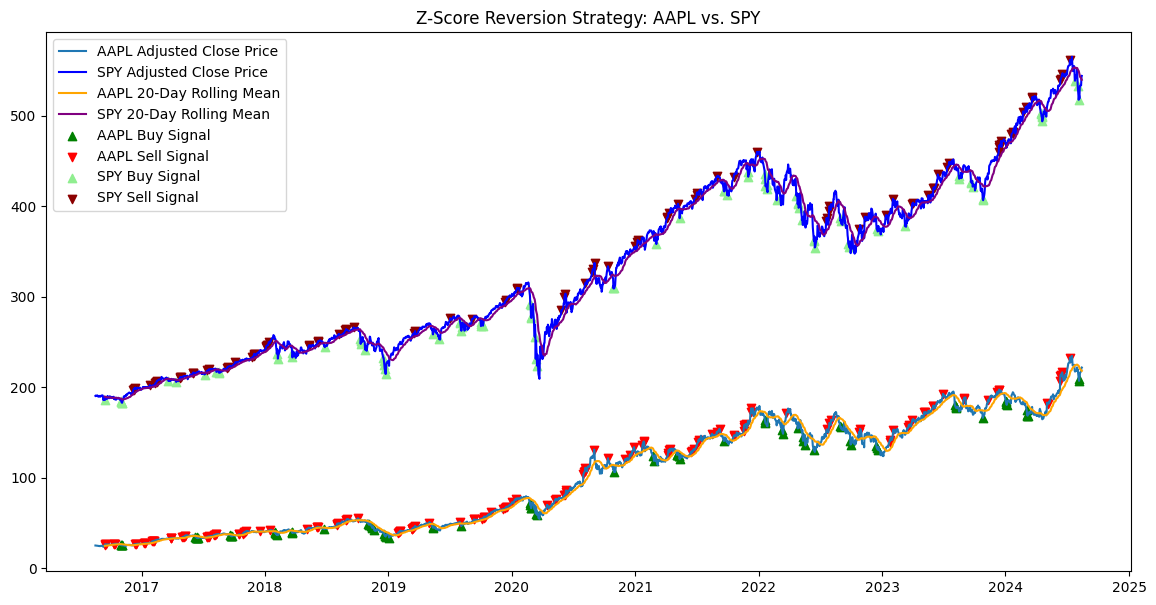

In [82]:
# Plotting Z-Score Reversion for AAPL vs. SPY
plt.figure(figsize=(14, 7))
plt.plot(df_flat['AAPL'], label='AAPL Adjusted Close Price')
plt.plot(df_flat['SPY'], label='SPY Adjusted Close Price', color='blue')
plt.plot(rolling_mean['AAPL'], label=f'AAPL {window}-Day Rolling Mean', color='orange')
plt.plot(rolling_mean['SPY'], label=f'SPY {window}-Day Rolling Mean', color='purple')
plt.scatter(df_flat.index, df_flat['AAPL'].where(z_score_signals['AAPL'] == 1), color='green', label='AAPL Buy Signal', marker='^', alpha=1)
plt.scatter(df_flat.index, df_flat['AAPL'].where(z_score_signals['AAPL'] == -1), color='red', label='AAPL Sell Signal', marker='v', alpha=1)
plt.scatter(df_flat.index, df_flat['SPY'].where(z_score_signals['SPY'] == 1), color='lightgreen', label='SPY Buy Signal', marker='^', alpha=1)
plt.scatter(df_flat.index, df_flat['SPY'].where(z_score_signals['SPY'] == -1), color='darkred', label='SPY Sell Signal', marker='v', alpha=1)
plt.title(f'Z-Score Reversion Strategy: AAPL vs. SPY')
plt.legend()
plt.show()